# Running HBV Model for FR000119

## Importing Python modules

In [1]:
!pip install "rich[jupyter]"
!pip install "geopandas"

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing
from ewatercycle.forcing import sources
from ewatercycle.models import HBV

## Choose region and time period

In [3]:
# name of the catchment
basin_name = "FR000119"

# defining dates
experiment_start_date = "2013-11-26T00:00:00Z"
experiment_end_date = "2019-12-31T00:00:00Z"

In [4]:
#Define Catchment Area
shapefile_path = Path.home() / "BEP-Elke" / "book" / "thesis_projects" / "BSc" / "2025_Q4_ElkeSchokking_CEG" / "work in progress" / "ShapefilesFR000119" / "FR000119.shp"

<Axes: >

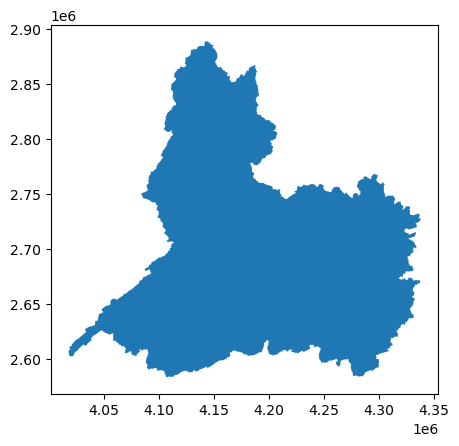

In [5]:
#check
catchment = gpd.read_file(shapefile_path)
catchment = catchment.to_crs(epsg=3035)
catchment["area_km2"] = catchment.geometry.area / 1e6  
basin_area = catchment["area_km2"].sum()
catchment.plot()

In [6]:
print(f"Basin area: {basin_area:.2f} km²")

Basin area: 48437.19 km²

In [7]:
# Location forcing files in home directory
forcing_path = Path.home() / "forcing" / "FR000119"/"ERA5"
forcing_path.mkdir(parents=True, exist_ok=True)

## Generate ERA 5 forcing

In [8]:
ERA5_forcing = sources["LumpedMakkinkForcing"].generate(
    dataset="ERA5",
    start_time=experiment_start_date,
    end_time=experiment_end_date,
    shape=shapefile_path,
)

In [9]:
#Save the ERA 5 forcing
output_path = Path.home() / "forcing" / "FR000119" / "ERA5"
output_path.mkdir(parents=True, exist_ok=True)

In [10]:
ERA5_forcing.save()

PosixPath('/home/elke/BEP-Elke/book/thesis_projects/BSc/2025_Q4_ElkeSchokking_CEG/work in progress/esmvaltool_output/ewcrep5yvtlv4f_20250525_104347/work/diagnostic/script/ewatercycle_forcing.yaml')

## Defining historical data from eStreams
The original CSV file had some formatting and encoding issues—like strange quotation marks and all the data crammed into a single column—which made it impossible to load with the usual pandas.read_csv() method. To work around this, I used a custom parser to manually extract the dates and discharge values.

In [33]:
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Discharge (m³/s)")
Q_obs = discharge_series[experiment_start_date:experiment_end_date]

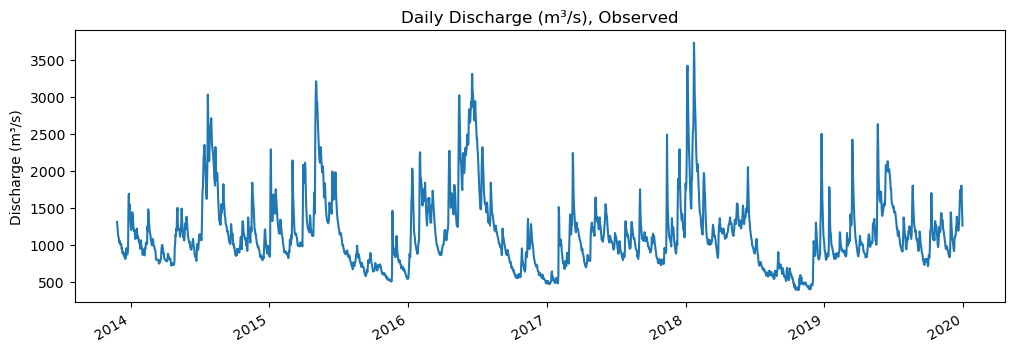

In [12]:
# Plot
Q_obs.plot(figsize=(12,4), title="Daily Discharge (m³/s), Observed")
plt.ylabel("Discharge (m³/s)")
plt.show()

## Load parameters from calibration

In [13]:
# # Parameters supervisor
# par_0 = [7.0850, 0.8370, 76.373, 1.1120, 0.2450, 7.8010, 0.0960, 0.0030, 0.2260]
# param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]

# # Initial storages for HBV (in mm)
# # [Si, Su, Sf, Ss, Sp]
# s_0 = np.array([0, 100, 0, 5, 0])

In [49]:
# Calibrated parameters RMSE & EMD
#par_0 = [3.0921, 0.928, 131.8813, 3.7768, 0.0578, 5.6994, 0.0168, 0.0002, 1.4708]
#param_names = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

#Calibrated parameters, logNSE & EMD
par_0 = [6.3785, 0.9656, 235.0548, 3.8811, 0.2353, 5.3018, 0.0244, 0.0055, 7.4328]
param_names = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM']

# Initial storages for HBV (in mm)
# [Si, Su, Sf, Ss, Sp]
s_0 = np.array([0, 100, 0, 5, 0])

In [50]:
# Create HBV model instance with prepared ERA5 forcing
model = HBV(forcing=ERA5_forcing)

config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
model.initialize(config_file)

In [51]:
# Run the model
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

model.finalize()

## Show results

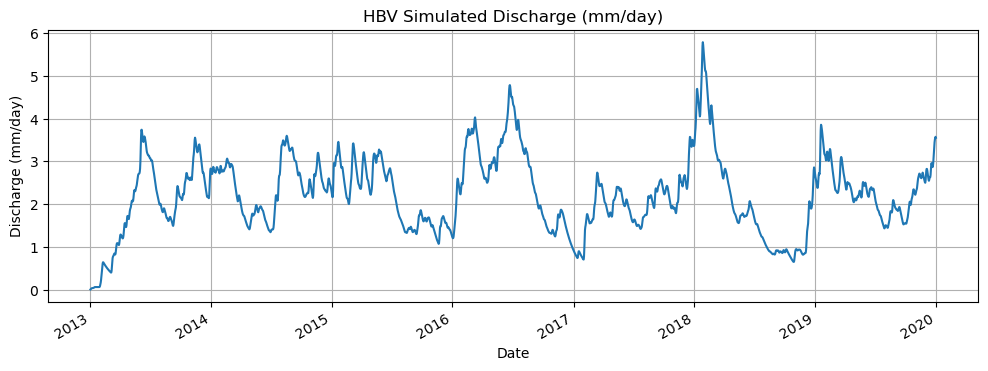

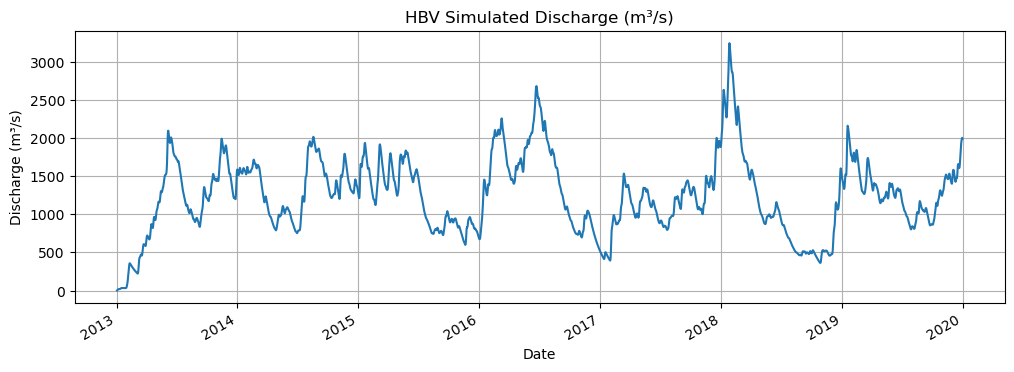

In [52]:
simulated_discharge = pd.Series(data=Q_m, index=time, name="Simulated Discharge")

# Plot mm/day
simulated_discharge.plot(figsize=(12, 4), title="HBV Simulated Discharge (mm/day)")
plt.ylabel("Discharge (mm/day)")
plt.xlabel("Date")
plt.grid()
plt.show()

# Convert HBV output (mm/day) to m³/s
def convert_to_m3s(Q_mmday, area_km2):
    return Q_mmday * area_km2 * 1e3 / 86400

# Convert simulated discharge
Q_sim_m3s = convert_to_m3s(simulated_discharge, basin_area)
Q_sim_m3s.name = "Simulated Discharge"

# Plot m³/s
Q_sim_m3s.plot(figsize=(12, 4), title="HBV Simulated Discharge (m³/s)")
plt.ylabel("Discharge (m³/s)")
plt.xlabel("Date")
plt.grid()
plt.show()

## Observed VS Simulated

In [53]:
Q_obs_m3s = discharge_series.copy()
Q_obs_m3s.name = "Observed Discharge"

# Convert both indices to timezone
Q_sim_m3s.index = Q_sim_m3s.index.tz_localize(None)
Q_obs_m3s.index = Q_obs_m3s.index.tz_localize(None)

# Align
start = max(Q_sim_m3s.index.min(), Q_obs_m3s.index.min())
end = min(Q_sim_m3s.index.max(), Q_obs_m3s.index.max())

Q_sim_aligned = Q_sim_m3s[start:end]
Q_obs_aligned = Q_obs_m3s[start:end]

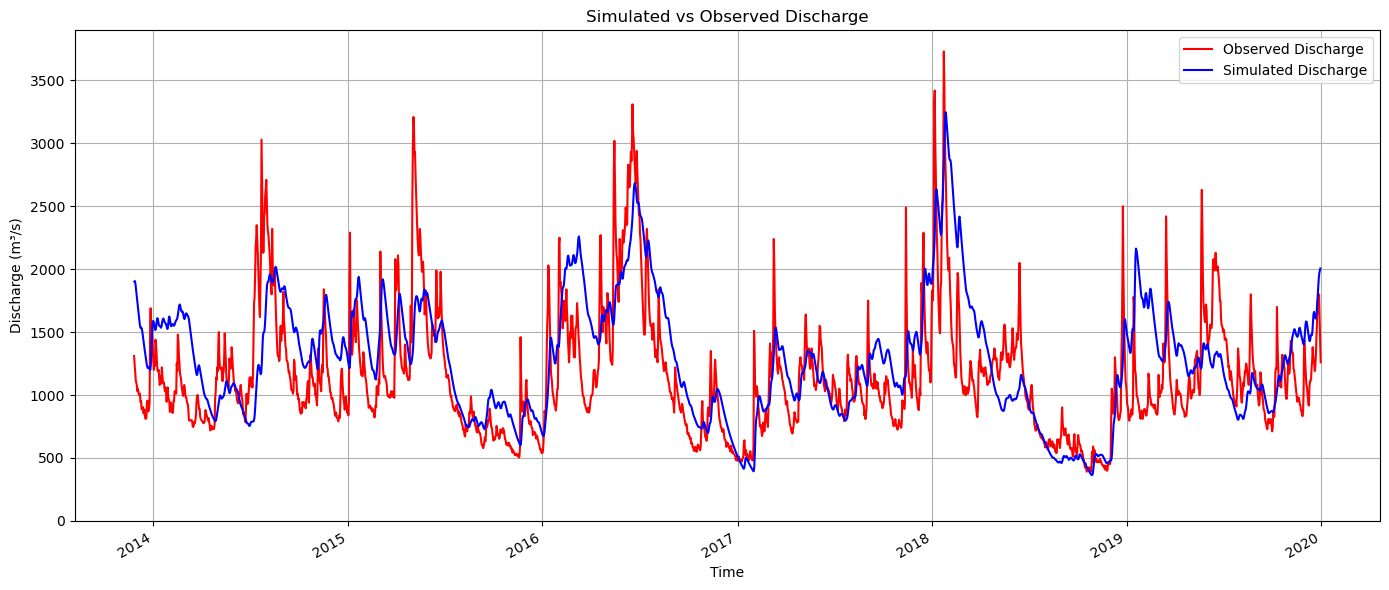

In [54]:
#Plot
plt.figure(figsize=(14, 6))
Q_obs_aligned.plot(label="Observed Discharge", color="red")
Q_sim_aligned.plot(label="Simulated Discharge", color="blue")
plt.title("Simulated vs Observed Discharge")
plt.ylabel("Discharge (m³/s)")
plt.xlabel("Time")

# Get current y-limits to create y ticks
ymin, ymax = plt.ylim()

# Define new ticks including 500
yticks = np.arange(0, ymax + 1, 500)
if 500 not in yticks:
    yticks = np.append(yticks, 500)
    yticks = np.sort(yticks)

# Set the ticks before showing the plot
plt.yticks(yticks)

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Low flows

In [55]:
from critical_days_module import classify_discharge_status, get_segments_final_color_safe

In [56]:
def plot_classified_discharge_pair(obs_series, sim_series, year, threshold=500):
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    for ax, data, label in zip(
        axes,
        [obs_series[str(year)], sim_series[str(year)]],
        ["Observed", "Simulated"]
    ):
        values = data.values
        days = list(range(1, len(values) + 1))

        statuses = classify_discharge_status(values)
        segments, colors = get_segments_final_color_safe(days, values, threshold)

        for (x_seg, y_seg), color in zip(segments, colors):
            ax.plot(x_seg, y_seg, color=color, linewidth=2.5)

        ax.axhline(threshold, color='blue', linestyle='--', label='Threshold (500 m³/s)')
        ax.set_ylabel("Discharge [m³/s]")
        ax.set_title(f"{label} Discharge - {year}")
        ax.grid(True)

    # Legenda op onderste subplot
    axes[-1].plot([], [], color='yellow', label='Caution (1–3d)')
    axes[-1].plot([], [], color='orange', label='Risk (4–7d)')
    axes[-1].plot([], [], color='red', label='Critical (>7d)')
    axes[-1].plot([], [], color='black', label='Normal')
    axes[-1].legend()
    axes[-1].set_xlabel("Day of Year")

    plt.tight_layout()
    plt.show()


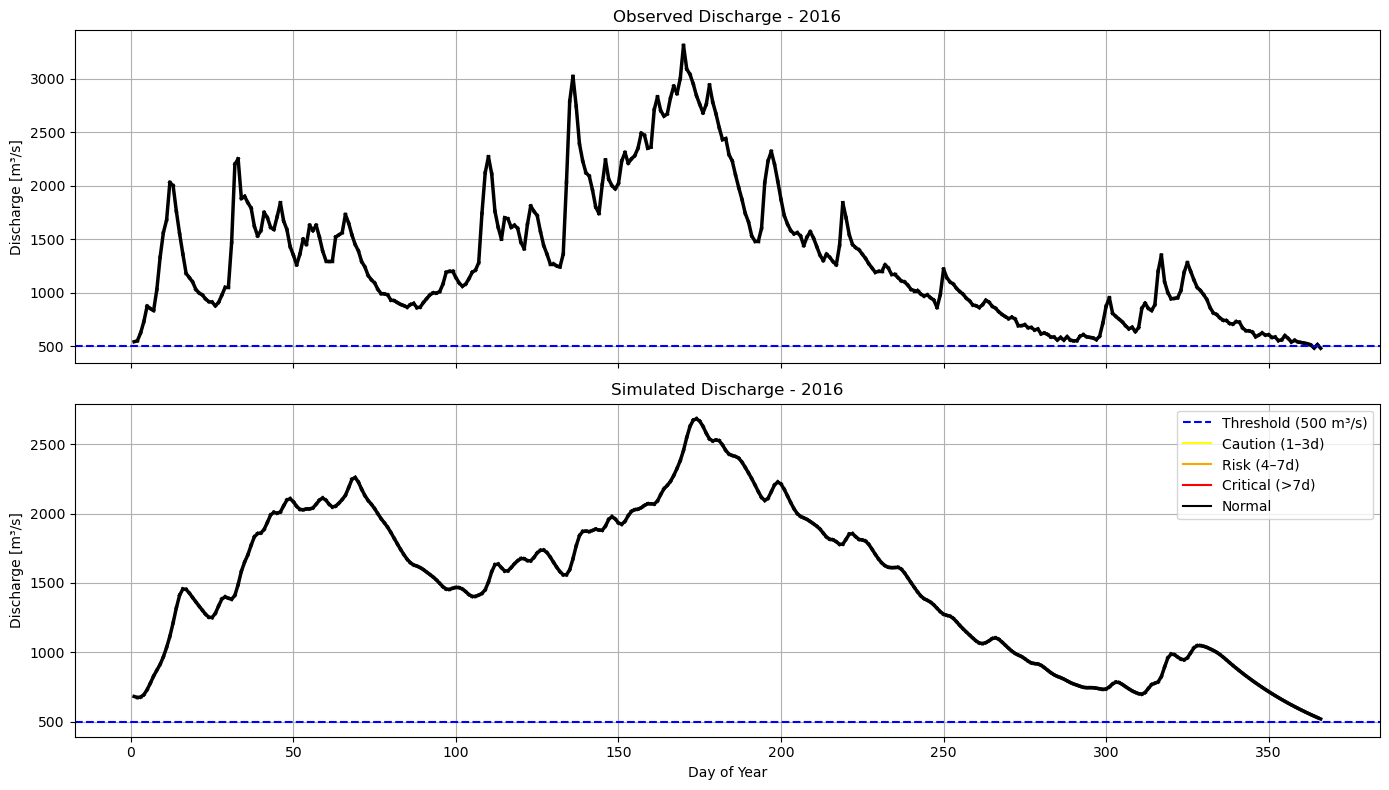

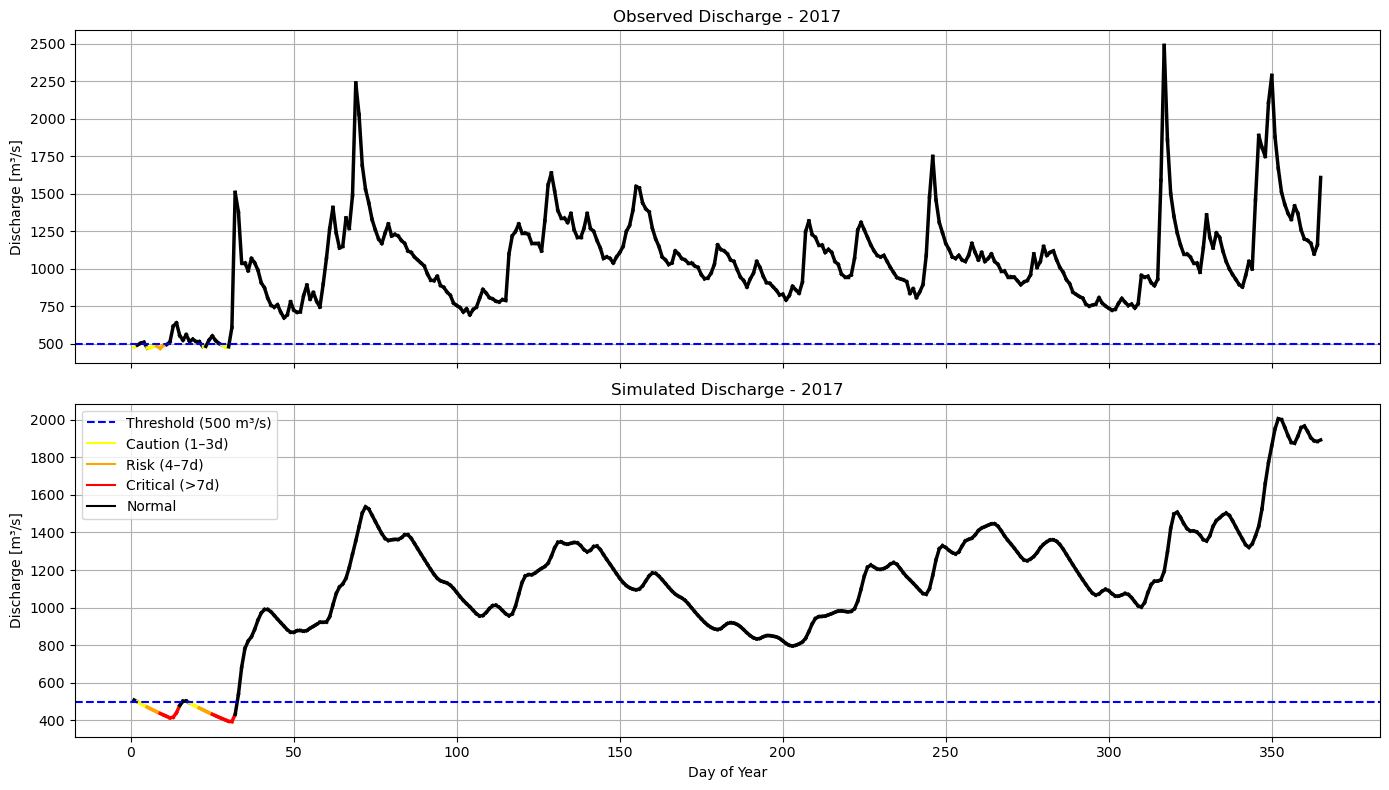

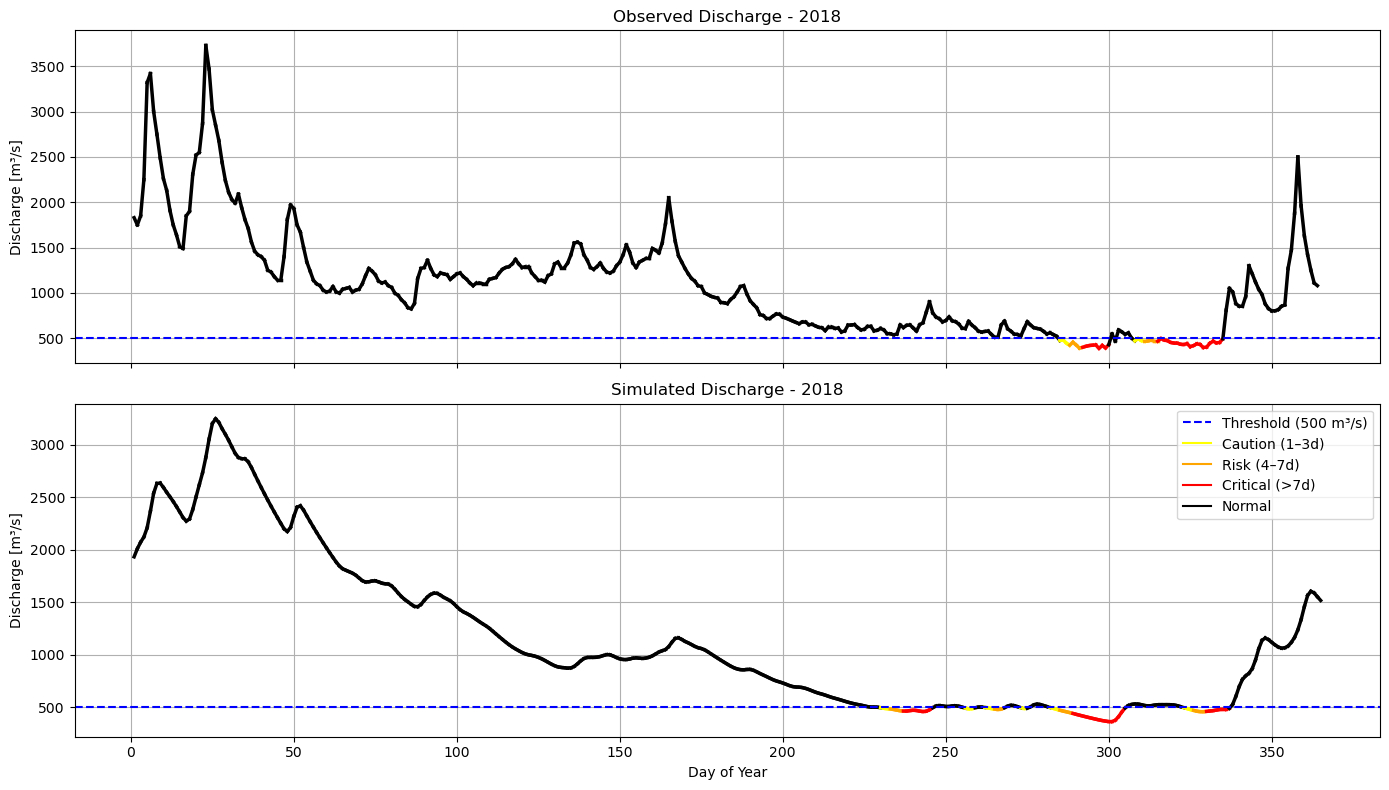

In [57]:
for year in [2016, 2017, 2018]:
    plot_classified_discharge_pair(Q_obs_aligned, Q_sim_aligned, year)

## Check drought analyser

In [58]:
from critical_days_module import droughts

In [59]:
Q_sim = Q_sim_m3s[start:end] #Convert Q_m to a time-indexed series (same length as Q_obs):

In [60]:
obs_droughts = droughts(Q_obs, basin_name="FR000119", q_crit=500)
sim_droughts = droughts(Q_sim, basin_name="FR000119", q_crit=500)

In [61]:
print("Observed droughts:")
display(obs_droughts.head())

print("Simulated droughts:")
display(sim_droughts.head())

Observed droughts:

,Drought Number,Start Date,Duration (days),Max Cumulative Deficit (m3/s),Cum Deficit List,Basin
0,1,2016-12-29 00:00:00+00:00,1,-17.0,[-17.0],FR000119
1,2,2016-12-31 00:00:00+00:00,3,-50.0,"[-20.0, -42.0, -50.0]",FR000119
2,3,2017-01-05 00:00:00+00:00,7,-125.0,"[-27.0, -52.0, -68.0, -83.0, -112.0, -121.0, -...",FR000119
3,4,2017-01-22 00:00:00+00:00,2,-32.0,"[-16.0, -32.0]",FR000119
4,5,2017-01-28 00:00:00+00:00,3,-47.0,"[-7.0, -28.0, -47.0]",FR000119


Simulated droughts:

,Drought Number,Start Date,Duration (days),Max Cumulative Deficit (m3/s),Cum Deficit List,Basin
0,1,2017-01-02 12:00:00,14,-655.872179,"[-0.8511053775612822, -11.172887244765548, -30...",FR000119
1,2,2017-01-18 12:00:00,15,-922.627946,"[-6.427836880796349, -22.171053864758335, -47....",FR000119
2,3,2018-08-18 12:00:00,17,-431.558512,"[-4.396025180987067, -14.237841460255822, -27....",FR000119
3,4,2018-09-13 12:00:00,4,-41.598242,"[-8.41325810562364, -22.980827949227262, -36.3...",FR000119
4,5,2018-09-19 12:00:00,7,-81.764643,"[-2.0818030415027238, -9.030502887532748, -21....",FR000119
